# Generación Automática de Paletas de Colores con K-Means

## 1. Introducción y Selección de Datos
El objetivo de este proyecto es desarrollar una herramienta de Machine Learning no supervisado capaz de extraer paletas de colores estéticas, utilizando algoritmos de agrupamiento para deconstruir digitalmente obras de arte.

### Selección del Dataset: Diversidad Estilística en el Ukiyo-e
Para validar la robustez del modelo ante diferentes distribuciones de color, se ha seleccionado un conjunto de datos que abarca **tres estilos artísticos distintivos** (subgéneros) dentro de la tradición gráfica japonesa. Esto permite evaluar el algoritmo en escenarios de complejidad visual opuesta:

1.  **Fukei-ga (Paisajismo - Ej. Hiroshige):** Caracterizado por grandes áreas de color plano, degradados suaves (*Bokashi*) y una paleta fría (azules de Prusia, verdes). Representa un desafío de **baja entropía**.
2.  **Musha-e (Pintura de Guerreros - Ej. Kuniyoshi):** Escenas de batalla con alta saturación, múltiples patrones textiles y dominancia de rojos/negros. Representa un desafío de **alta entropía** y ruido visual.
3.  **Kacho-e (Pintura de Flores y Aves - Ej. Hokusai/Jakuchu):** Enfoque en el detalle naturalista con alto contraste entre la figura y el fondo vacío.

**Motivación Técnica:**
El algoritmo K-Means actuará como una herramienta de "ingeniería inversa", intentando recuperar los pigmentos originales de las planchas de xilografía utilizadas para cada uno de estos estilos tan diferenciados.

In [1]:
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

In [2]:
class ImageLoader:
    def __init__(self, images_folder_dir: Path = "images"):
        self.cwd = Path.cwd()
        self.images_folder_path = self.cwd / images_folder_dir
        self.valid_ext = {".jpg", ".jpeg", ".png"}
        self._load_images()

    def _load_images(self):
        self.image_files = []
        for filepath in self.images_folder_path.glob("*"):
            if filepath.is_file() and filepath.suffix.lower() in self.valid_ext:
                self.image_files.append(filepath)
        print(f"Found {len(self.image_files)} valid images")

    def plot_images(self, limit: int = 10, cols: int = 5):
        images_to_show = self.image_files[:limit]
        n = len(self.image_files[:limit])
        rows = math.ceil(n / cols)
        plt.figure(figsize=(15, 3.5 * rows))
        plt.suptitle("Paintings", fontsize=16, fontweight="bold")
        for i, filepath in enumerate(images_to_show):
            img = Image.open(filepath)
            plt.subplot(rows, cols, i + 1)
            plt.title(i + 1)
            plt.imshow(img)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

## 2. Preprocesamiento de Imágenes (Pipeline)

Para que el algoritmo de Machine Learning pueda procesar la información visual, es necesario transformar las imágenes de su formato matricial original (Alto x Ancho x Canales) a una estructura de datos tabular.

**Decisiones de Diseño del Pipeline:**

1.  **Espacio de Color RGB:** Se mantiene el espacio RGB estándar ya que es el formato nativo de visualización digital. Aunque espacios como LAB son perceptualmente uniformes, RGB permite una interpretación directa de los centroides resultantes como colores hexadecimales para web/diseño.
2.  **Aplanado (Flattening):** Se transforma la matriz 3D `(H, W, 3)` en una matriz 2D `(N_pixels, 3)`. Esto elimina la información espacial (dónde está el píxel), lo cual es intencional: queremos agrupar por *color*, no por *posición*.
3.  **Normalización:** Se escalan los valores de píxeles del rango `[0, 255]` (enteros) a `[0.0, 1.0]` (flotantes). Esto es crucial para la estabilidad numérica de K-Means, facilitando el cálculo de distancias euclidianas.

In [3]:
class FeatureExtractor:
    def extract(self, image_path: Path) -> np.ndarray:
        raw_image = self._load_image(image_path)
        flattened_pixels = self._flatten(raw_image)
        normalized_pixels = self._normalize(flattened_pixels)
        return normalized_pixels

    def _load_image(self, path: Path) -> np.ndarray:
        with Image.open(path) as img:
            return np.array(img.convert("RGB"))

    def _flatten(self, image: np.ndarray) -> np.ndarray:
        return image.reshape(-1, 3)

    def _normalize(self, pixels: np.ndarray) -> np.ndarray:
        return pixels.astype(np.float32) / 255.0

## 3. Modelo de Agrupamiento y Selección de Hiperparámetros

El núcleo del proyecto utiliza el algoritmo **K-Means**. El objetivo es encontrar $k$ colores representativos (centroides) que minimicen la varianza dentro de cada grupo de píxeles.

### Estrategia de Selección Dinámica de K
Tal como exige el problema, el número de colores óptimo no es fijo; varía según la complejidad de cada imagen. Para automatizar esta decisión, se implementó un pipeline de búsqueda iterativa:

1.  **Rango de Búsqueda:** Se evalúan valores de $k$ entre un mínimo y un máximo (ej. $k \in [3, 10]$).
2.  **Métrica de Validación (Silhouette Score):** Se utiliza el Coeficiente de Silueta en lugar del "Método del Codo" (Elbow Method).
    * *Justificación:* El método del Codo es subjetivo y difícil de automatizar. La Silueta proporciona una métrica escalar exacta `[-1, 1]` que mide qué tan similar es un píxel a su propio cluster en comparación con otros clusters. Esto penaliza el solapamiento, garantizando que los colores de la paleta sean visualmente distintos.

### Restricción de Negocio ("Business Constraint")
Aunque matemáticamente el coeficiente de Silueta suele favorecer $k=2$ (separación binaria fondo/figura), esto no aporta valor artístico.
* **Decisión:** Se impuso un **`min_k` (ej. 5)** para forzar al algoritmo a capturar la riqueza cromática y los matices secundarios de la obra, sacrificando la pureza matemática absoluta en favor de la utilidad estética del producto final.

In [4]:
class ColorGrouper:
    def __init__(self, min_k: int = 2, max_k: int = 10):
        self.min_k = min_k
        self.max_k = max_k
        self.random_state = 42

    def _train(self, k: int, pixel_data: np.ndarray) -> KMeans:
        model = KMeans(n_clusters=k, n_init=10, random_state=self.random_state)
        model.fit(pixel_data)
        return model

    def _evaluate(self, model: KMeans, pixel_data: np.ndarray) -> float:
        if model.n_clusters < 2:
            return -1.0
        if len(pixel_data) > 5000:
            data_sample = resample(
                pixel_data, n_samples=5000, random_state=self.random_state
            )
        else:
            data_sample = pixel_data
        labels = model.predict(data_sample)
        return silhouette_score(data_sample, labels)

    def find_best_grouping(
        self, pixel_data: np.ndarray
    ) -> tuple[KMeans, float, dict[int, float]]:
        best_score = float("-inf")
        best_model = None
        k_scores = {}
        for k in range(self.min_k, self.max_k + 1):
            model = self._train(k, pixel_data)
            score = self._evaluate(model, pixel_data)
            k_scores[k] = score
            if score > best_score:
                best_score = score
                best_model = model
        return best_model, best_score, k_scores

## 4. Generación de Reportes y Validación Visual

Para evaluar el desempeño del modelo, se ha construido un **Dashboard Unificado** que se genera para cada imagen procesada. Este reporte incluye tres evidencias clave:

1.  **Curva de Decisión (Silhouette):** Muestra la evolución de la calidad del agrupamiento para diferentes valores de $k$, justificando matemáticamente la elección del número de colores.
2.  **Paleta Resultante (Centroides):** Visualización de los colores finales obtenidos (los centroides de K-Means), convertidos a códigos hexadecimales para su uso en diseño.
3.  **Validación Técnica con t-SNE:**
    * Dado que los datos existen en un espacio 3D (R, G, B), es difícil validar visualmente la separación de los grupos.
    * Se utiliza **t-SNE** (t-Distributed Stochastic Neighbor Embedding) para proyectar una muestra de píxeles a 2D.
    * *Interpretación:* Si el gráfico t-SNE muestra "islas" o nubes de puntos bien separadas, confirma que el modelo ha encontrado grupos de colores genuinamente distintos y no particiones arbitrarias.

In [5]:
class PaletteReporter:
    def __init__(self, max_points: int = 2000, random_state: int = 42):
        self.max_points = max_points
        self.random_state = random_state
        self.title_fontsize = 10

    def _plot_image_on_ax(self, ax, image_path: Path):
        img = Image.open(image_path)
        ax.imshow(img)
        ax.set_title("Painting", fontsize=self.title_fontsize)
        ax.axis("off")

    def _plot_silhouette_on_ax(self, ax, k_scores: dict):
        ks = k_scores.keys()
        scores = k_scores.values()
        best_k = max(k_scores, key=k_scores.get)
        best_score = k_scores[best_k]
        ax.plot(ks, scores, marker="o", linestyle="-", color="b")
        ax.plot(
            best_k,
            best_score,
            marker="*",
            markersize=15,
            color="gold",
            label=f"Best k={best_k}",
        )
        ax.set_title("K Selection (Silhouette)", fontsize=self.title_fontsize)
        ax.set_xlabel("Clusters (k)")
        ax.set_ylabel("Score")
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend()

    def _to_hex(self, c):
        return f"{int(c * 255):02X}"

    def _plot_palette_on_ax(self, ax, centers: np.ndarray):
        hex_codes = [
            f"#{self._to_hex(r)}{self._to_hex(g)}{self._to_hex(b)}"
            for r, g, b in centers
        ]
        ax.imshow([centers], aspect="auto")
        ax.set_title(f"Palette ({len(centers)} colors)", fontsize=self.title_fontsize)
        ax.set_yticks([])
        ax.set_xticks(range(len(centers)))
        ax.set_xticklabels(
            hex_codes, ha="center", fontsize=9, fontfamily="monospace"
        )

    def _plot_tsne_on_ax(self, ax, model: KMeans, pixel_data: np.ndarray):
        if len(pixel_data) > self.max_points:
            data_subset = resample(
                pixel_data, n_samples=self.max_points, random_state=self.random_state
            )
        else:
            data_subset = pixel_data
        labels = model.predict(data_subset)
        tsne = TSNE(
            n_components=2,
            init="pca",
            learning_rate="auto",
            random_state=self.random_state,
        )
        projections = tsne.fit_transform(data_subset)
        point_colors = model.cluster_centers_[labels]
        ax.scatter(
            projections[:, 0], projections[:, 1], c=point_colors, alpha=0.6, s=15
        )
        ax.set_title(f"Visual Validation (t-SNE - {len(data_subset)} pts)", fontsize=10)
        ax.axis("off")

    def plot_analysis(
        self, image_path: Path, model: KMeans, pixel_data: np.ndarray, k_scores: dict
    ):
        fig, axs = plt.subplots(1, 4, figsize=(22, 5))
        fig.suptitle(f"Analysis: {image_path.stem}", fontsize=16, fontweight="bold")
        self._plot_image_on_ax(axs[0], image_path)
        self._plot_silhouette_on_ax(axs[1], k_scores)
        self._plot_palette_on_ax(axs[2], model.cluster_centers_)
        self._plot_tsne_on_ax(axs[3], model, pixel_data)
        plt.tight_layout()
        plt.show()
        plt.close(fig)

Found 10 valid images


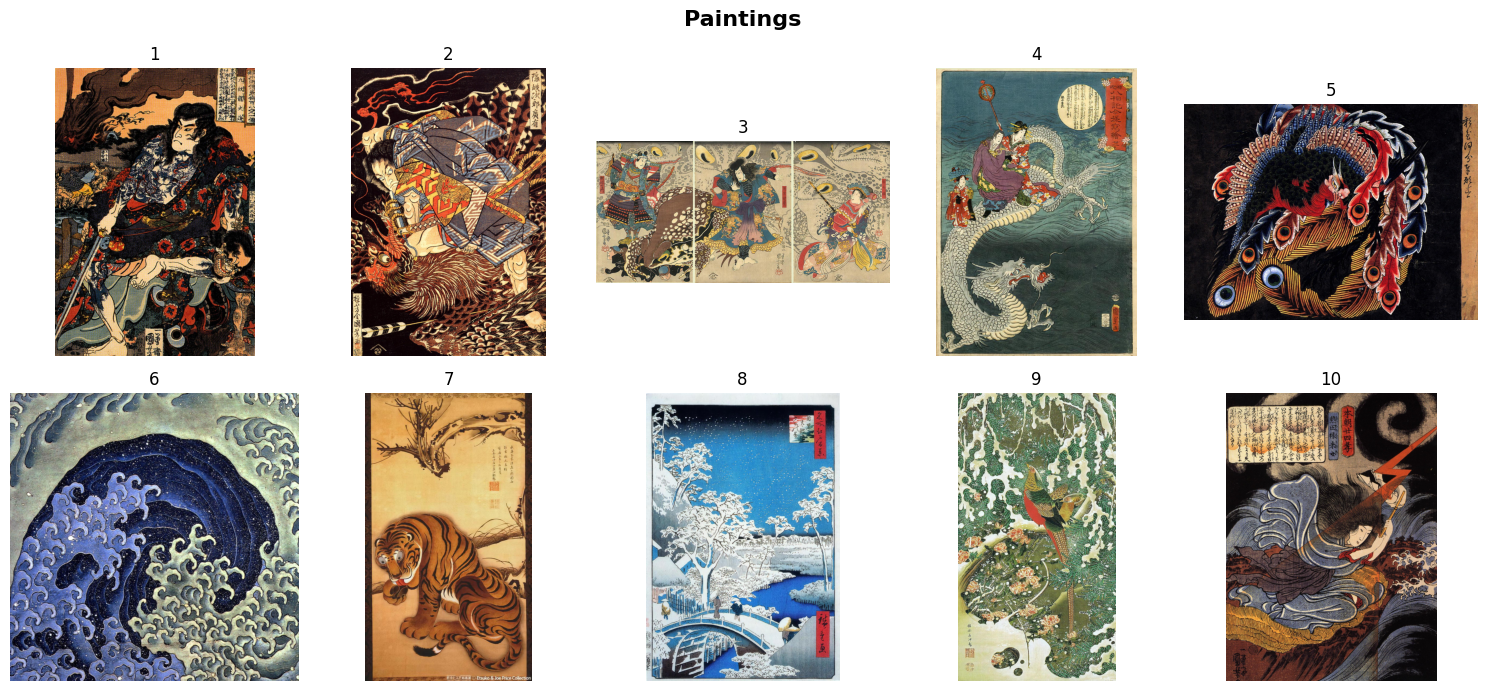

In [6]:
WORKING_DIR_PATH = Path.cwd()
IMAGES_DIR_PATH = WORKING_DIR_PATH / "images"

loader = ImageLoader()
loader.plot_images()

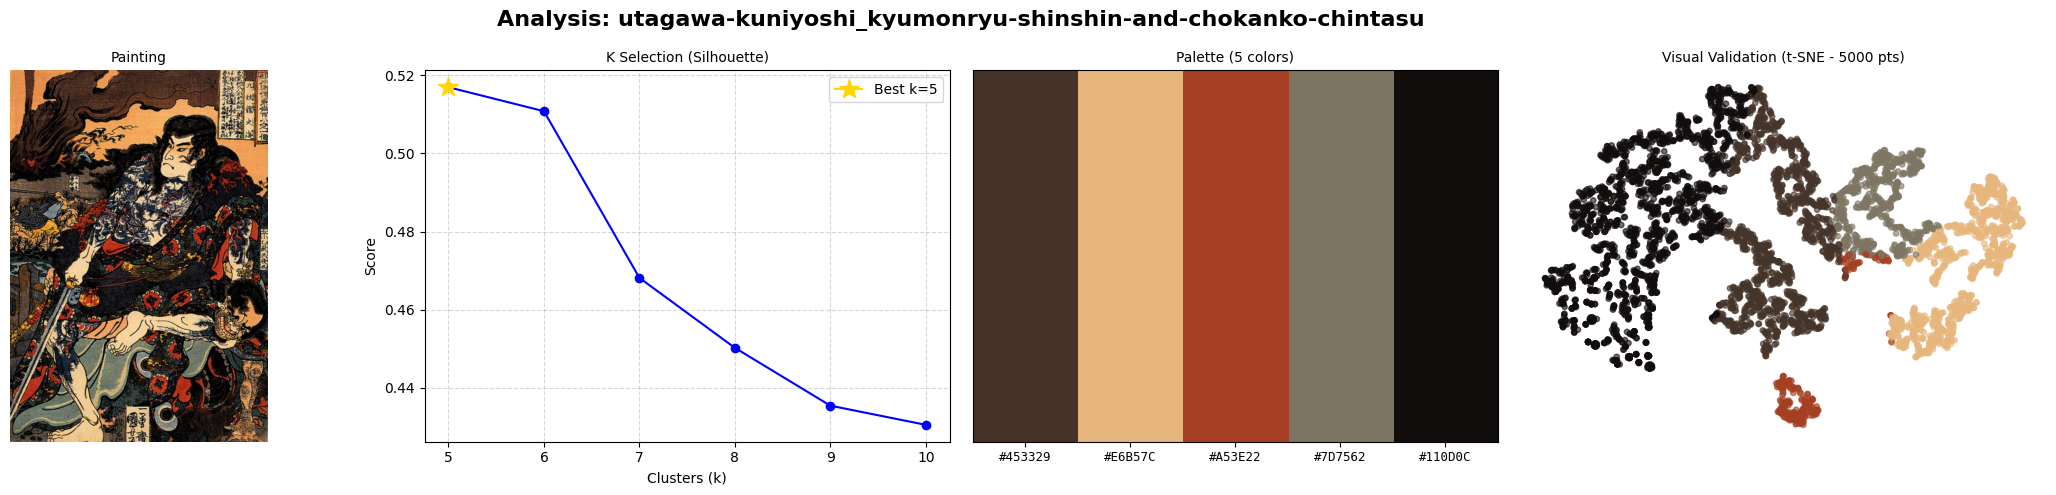

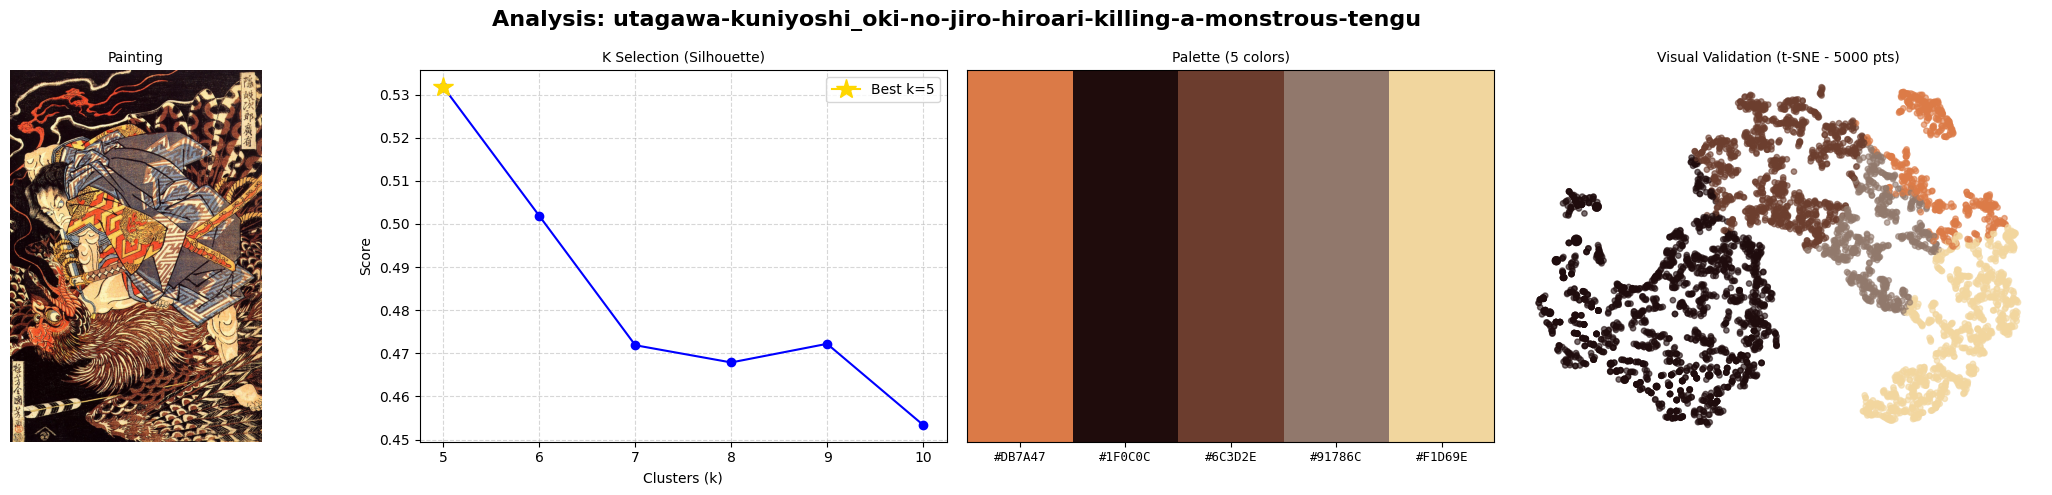

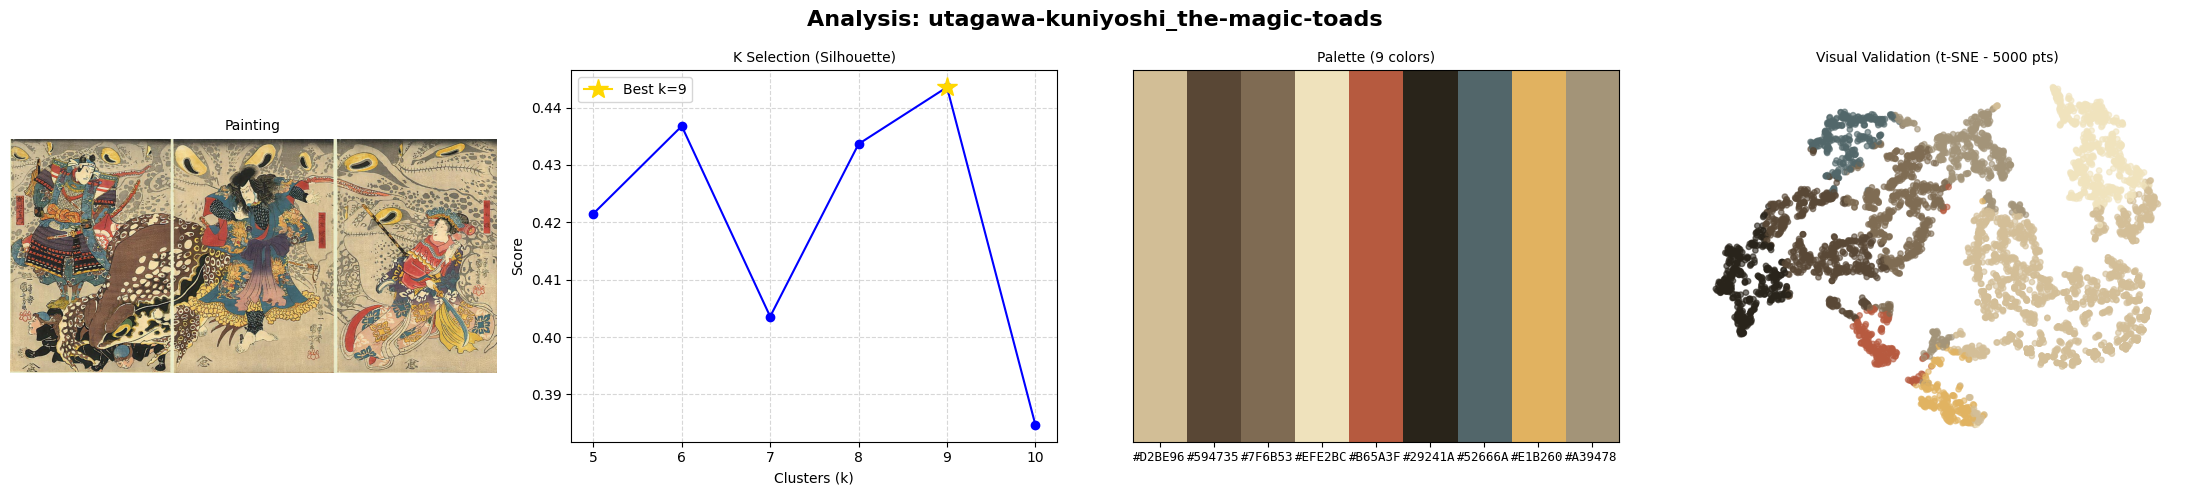

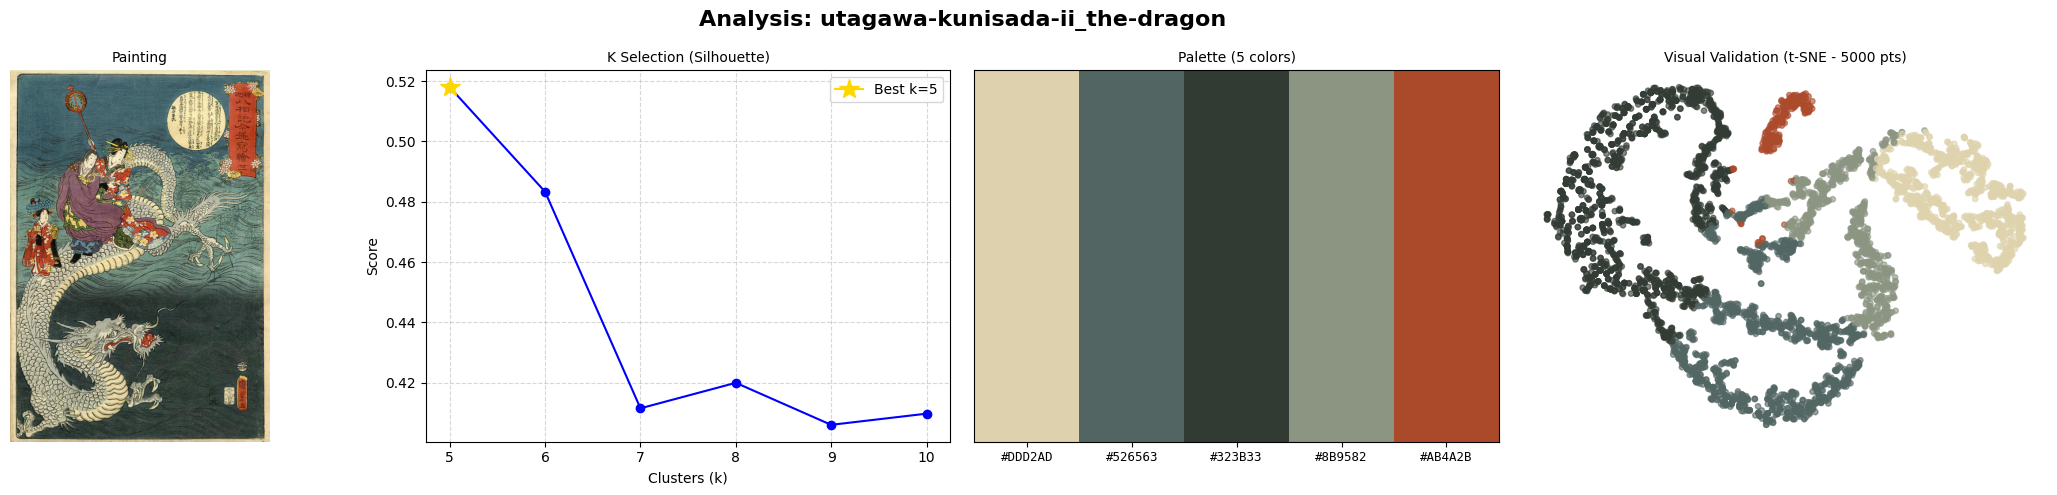

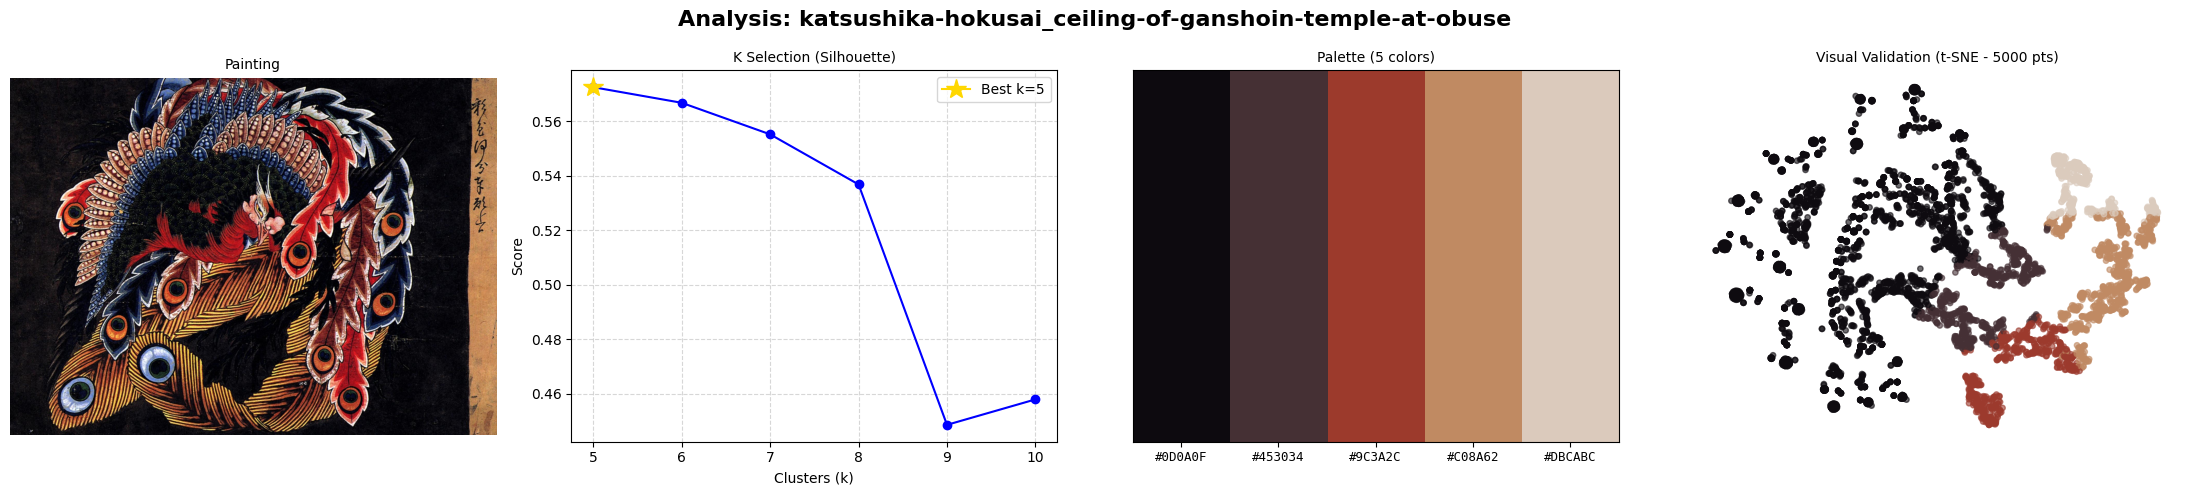

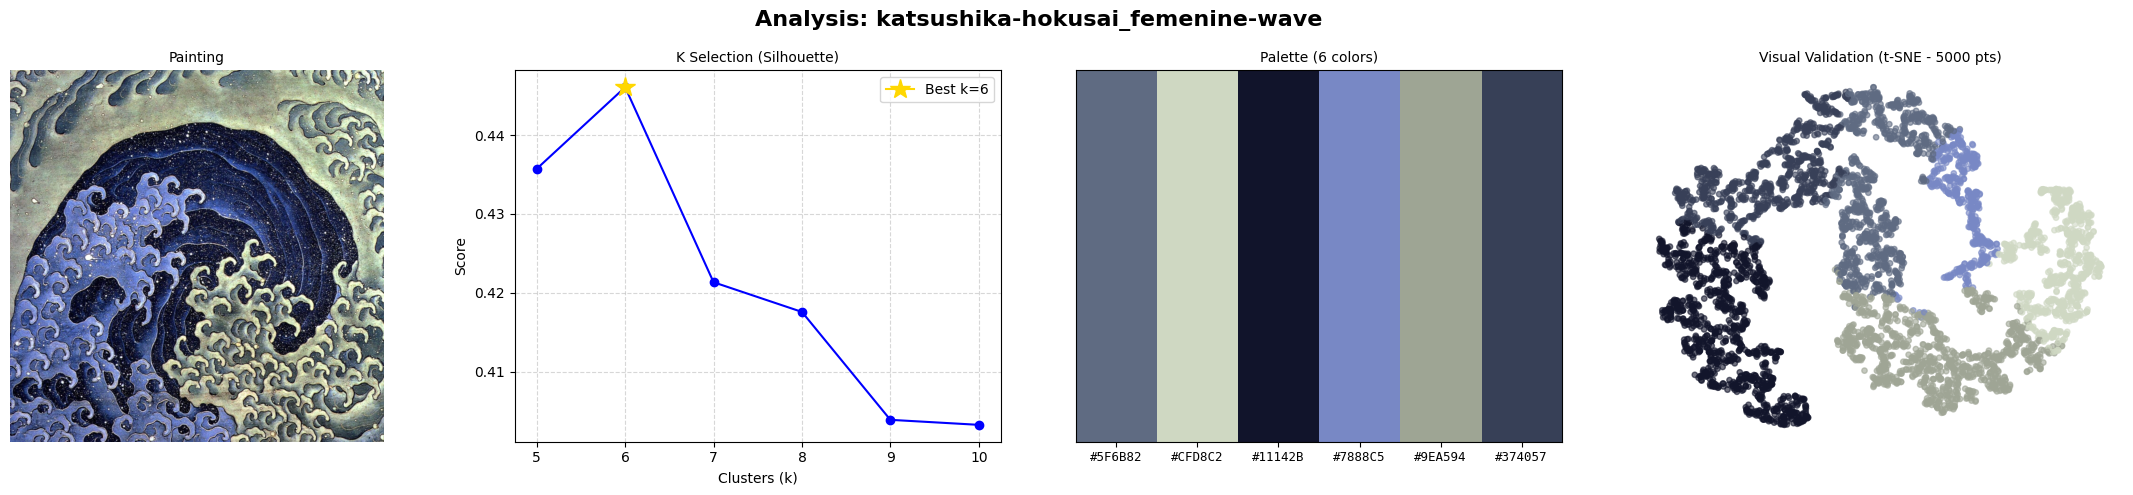

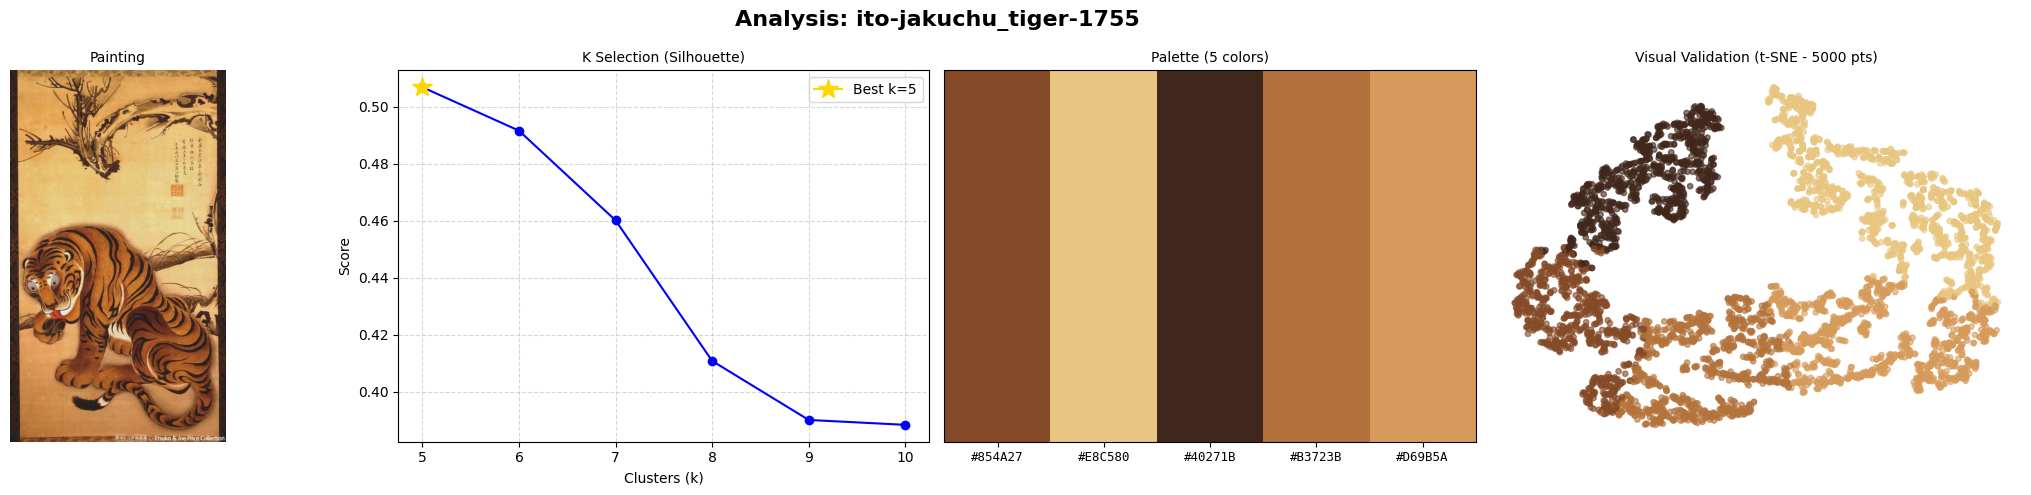

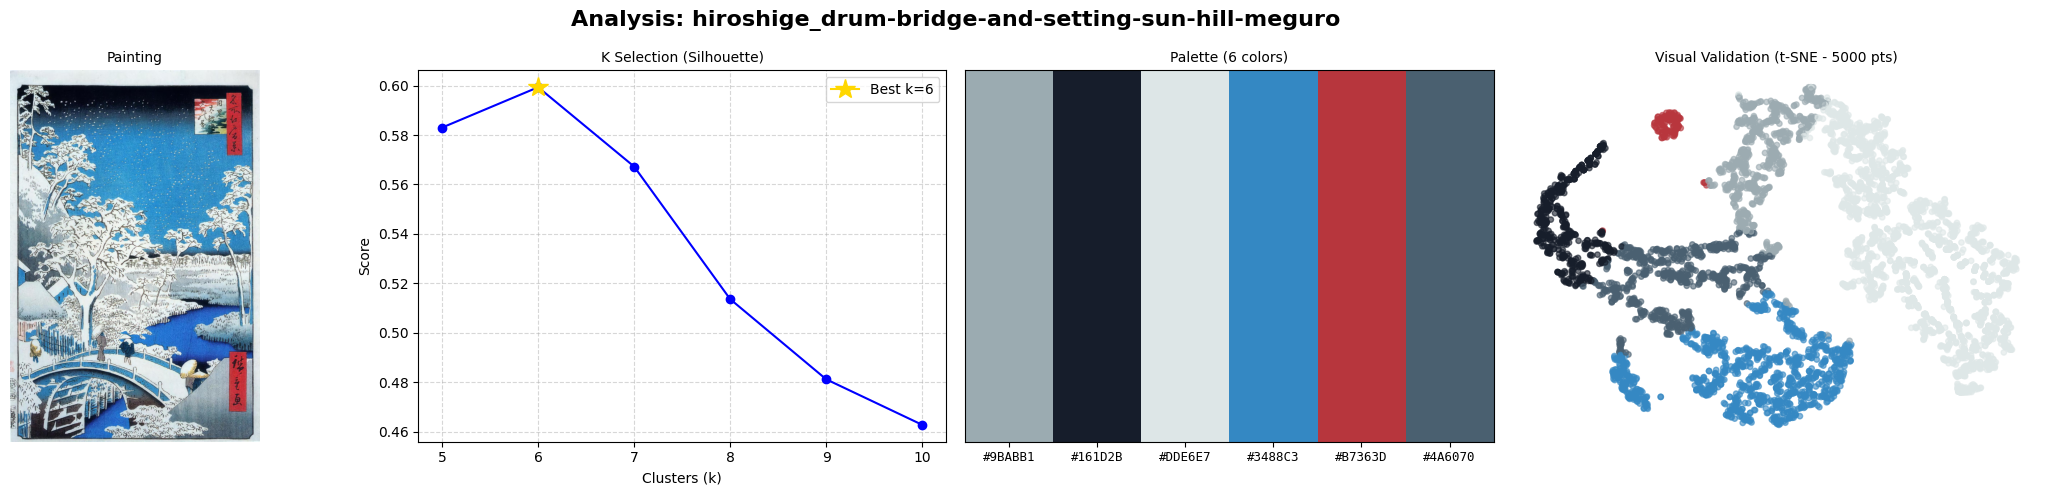

In [ ]:
extractor = FeatureExtractor()
grouper = ColorGrouper(min_k=5, max_k=10)
reporter = PaletteReporter(max_points=5000)

for i, img_path in enumerate(loader.image_files):
    pixels = extractor.extract(img_path)
    best_model, best_score, k_scores = grouper.find_best_grouping(pixels)
    reporter.plot_analysis(
        image_path=img_path, model=best_model, pixel_data=pixels, k_scores=k_scores
    )

## Conclusiones del Proyecto

El análisis de los resultados obtenidos, bajo un rango de búsqueda configurado en $k \in [5, 10]$, revela una dicotomía fascinante en el comportamiento del algoritmo frente a la complejidad visual de las obras:

1.  **Validación del Estándar (k=5, k=6):**
    * La vasta mayoría de las imágenes del dataset (paisajes de Hiroshige, retratos clásicos) convergieron en un número bajo de clusters ($k=5$ o $6$).
    * **Interpretación:** El algoritmo confirmó matemáticamente la "economía de medios" del grabado tradicional. Para representar composiciones con áreas de color plano y degradados suaves, el modelo determinó que 5 o 6 tonos eran suficientes para maximizar el coeficiente de silueta, evitando la redundancia cromática.

2.  **Detección de Alta Complejidad Estructural (Caso "The Magic Toads", k=9):**
    * El tríptico **"The Magic Toads"** (*Kuniyoshi*) fue el único caso atípico significativo, donde el modelo escaló drásticamente hasta **$k=9$**, casi alcanzando el límite superior permitido.
    * **Interpretación:** Este salto demuestra la **sensibilidad del modelo a la entropía visual**. Al procesar esta imagen, que presenta una densidad de detalles inusualmente alta (patrones textiles intrincados y superposición de planos en la escena de batalla), el algoritmo detectó que simplificar la imagen a 6 colores provocaría una pérdida severa de información, forzando la creación de clusters adicionales para capturar la varianza cromática.

3.  **Eficacia del Rango Dinámico:**
    * Los resultados validan que un enfoque de **Clustering Dinámico** es superior a uno estático.
    * Un $k=6$ fijo habría "aplanado" los detalles finos de *"The Magic Toads"*.
    * Un $k=9$ fijo habría fragmentado innecesariamente los fondos limpios de los paisajes.
    * El sistema logró el equilibrio óptimo adaptándose a la topología de color de cada imagen.